In [1]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

using gpu 4


In [2]:
#Checking wich GPU is beeing used

!nvidia-smi

Thu Dec  9 17:55:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 40%   67C    P2   187W / 250W |   9365MiB / 11019MiB |     61%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [3]:
#Load data
data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/whole_second/mfcc/less_100_5_speaker1.npy'

data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/whole_second/mfcc/less_100_5_speaker2.npy'

labels_dir = 'dialogue/Dataset/SameVoiceDetection/whole_second/mfcc/less_100_5_labels.npy'


data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
#data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
#data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels)

(80000, 40, 32) (80000, 40, 32)
[ True False  True ... False  True False]


In [4]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_val, y_train, y_val = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_test, y_train, y_test = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_val, y_train, y_val = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_test, y_train, y_test = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [5]:
X1_train = torch.from_numpy(X1_train).float()

X2_train = torch.from_numpy(X2_train).float()

y_train = torch.from_numpy(y_train).float()

X1_val = torch.from_numpy(X1_val).float()

X2_val = torch.from_numpy(X2_val).float()

y_val = torch.from_numpy(y_val).float()

X1_test = torch.from_numpy(X1_test).float()

X2_test = torch.from_numpy(X2_test).float()

y_test = torch.from_numpy(y_test).float()

print(X2_train.shape, y_train.shape)

print(X2_train[0])


torch.Size([51200, 40, 32]) torch.Size([51200])
tensor([[-114.1354,  -90.0481,  -86.3927,  ..., -191.1191, -284.9040,
         -318.1107],
        [ 134.8499,  138.1706,  133.0945,  ...,  128.4754,  147.4008,
          143.7569],
        [  25.3218,   10.2298,  -15.6011,  ...,   -1.0069,    2.9560,
           18.2484],
        ...,
        [  -0.8694,   -2.0489,   -1.6732,  ...,  -11.9050,   -9.7136,
           -5.7097],
        [  -2.4932,   -1.4815,    0.4368,  ...,   -7.6460,   -9.3230,
           -5.4039],
        [   7.7518,    1.6096,   -4.5829,  ...,    5.5616,    7.5363,
           -1.4921]])


In [6]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=3, stride = 1) #40 input channels, 40 output channels
        self.conv2 = nn.Conv1d(40, 60, kernel_size=3, stride = 1) #40 input channels from previous Conv. layer, 80 out
        self.conv3 = nn.Conv1d(60, 80, kernel_size=3, stride = 1, padding_mode= 'zeros')

        self.fc1 = nn.Linear(320, 200) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        
        x = x.reshape(len(x), -1)
        batch_size = len(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

In [7]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [8]:
train_ds = TensorDataset(X1_train, X2_train, y_train)
val_ds = TensorDataset(X1_val, X2_val, y_val)

In [9]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X1_train = X1_train.to(device)
# X2_train = X2_train.to(device)
# y_train = y_train.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)

X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)

CNN = CNN.to(device)
criterion = criterion.to(device)
print(device)

cuda


In [11]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [12]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)
    
Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val', 'val_loss', 'train_loss'])
    
for epoch in range(200):
    y_acc = torch.empty((batch_size),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((batch_size), device = 'cuda')
    for x1, x2, y in train_dl:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = CNN(x1, x2)
        y_pred = y_pred.squeeze()
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
    if epoch % 1 == 0:


        train_acc = calculate_accuracy(y_acc, CNN.post_forward(y_pred_acc))
    
        y_val_pred = CNN(X1_val, X2_val)
        y_val_pred = y_val_pred.squeeze()
        val_loss = criterion(y_val_pred, y_val)
    
        val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
    
        result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc), 'val_loss': round_tensor(val_loss), 'train_loss': round_tensor(train_loss)}

        Results = Results.append(result, ignore_index=True)

        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')

epoch 0
Train set - loss: 0.528, accuracy: 0.566
val  set - loss: 0.55, accuracy: 0.72

epoch 1
Train set - loss: 0.354, accuracy: 0.752
val  set - loss: 0.482, accuracy: 0.766

epoch 2
Train set - loss: 0.323, accuracy: 0.782
val  set - loss: 0.443, accuracy: 0.8

epoch 3
Train set - loss: 0.241, accuracy: 0.815
val  set - loss: 0.397, accuracy: 0.826

epoch 4
Train set - loss: 0.191, accuracy: 0.833
val  set - loss: 0.376, accuracy: 0.836

epoch 5
Train set - loss: 0.165, accuracy: 0.842
val  set - loss: 0.363, accuracy: 0.844

epoch 6
Train set - loss: 0.148, accuracy: 0.849
val  set - loss: 0.352, accuracy: 0.851

epoch 7
Train set - loss: 0.138, accuracy: 0.856
val  set - loss: 0.341, accuracy: 0.858

epoch 8
Train set - loss: 0.135, accuracy: 0.862
val  set - loss: 0.332, accuracy: 0.862

epoch 9
Train set - loss: 0.128, accuracy: 0.866
val  set - loss: 0.323, accuracy: 0.866

epoch 10
Train set - loss: 0.124, accuracy: 0.873
val  set - loss: 0.312, accuracy: 0.872

epoch 11
Trai

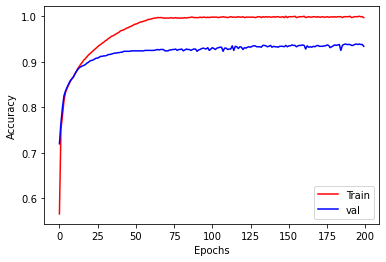

     Epoch  Acc_train  Acc_val  val_loss  train_loss
0      0.0      0.566    0.720     0.550       0.528
1      1.0      0.752    0.766     0.482       0.354
2      2.0      0.782    0.800     0.443       0.323
3      3.0      0.815    0.826     0.397       0.241
4      4.0      0.833    0.836     0.376       0.191
..     ...        ...      ...       ...         ...
195  195.0      0.999    0.938     0.988       0.000
196  196.0      1.000    0.939     1.015       0.000
197  197.0      0.999    0.938     1.068       0.000
198  198.0      0.999    0.938     1.117       0.000
199  199.0      0.997    0.934     1.093       0.000

[200 rows x 5 columns]


In [15]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_val,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

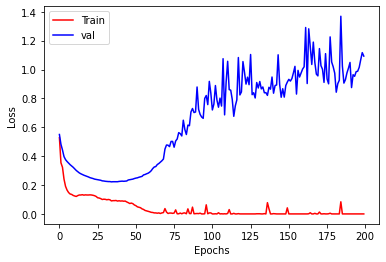

In [16]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.val_loss,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [17]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.95      0.92      0.93      8009
     Same Voice       0.92      0.95      0.93      7991

       accuracy                           0.93     16000
      macro avg       0.93      0.93      0.93     16000
   weighted avg       0.93      0.93      0.93     16000



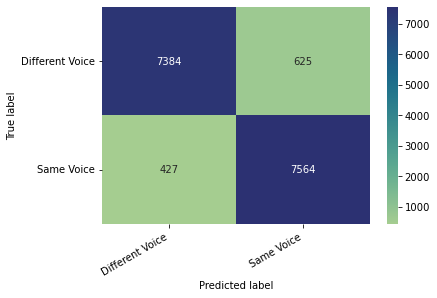

In [18]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [19]:
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.95      0.91      0.93      6295
     Same Voice       0.92      0.95      0.93      6505

       accuracy                           0.93     12800
      macro avg       0.93      0.93      0.93     12800
   weighted avg       0.93      0.93      0.93     12800



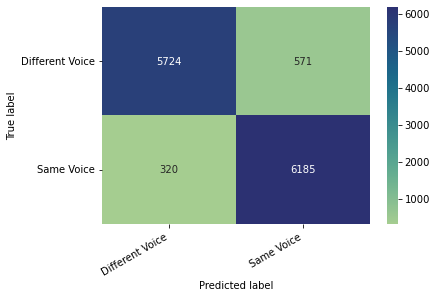

In [20]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
